# Training data preparation

Here we transform and resample empirical retinotopic maps estimated with [SamSrf](https://github.com/felenitaribeiro/pRFmodeling_SamSrf) for model training and model selection. We will perform the following steps:

1. We transform angle maps to range from 0-360 degrees;
2. We resample data from native to fs_average space;
3. We compare SamSrf fits against the ones provided by the HCP dataset.

## Import libraries and functions

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import sys
import os
import scipy
import os.path as osp

sys.path.append('..')

from functions.visualization import retinotopic_map_plot
from deepRetinotopy_TheToolbox.utils.rois import ROI_WangParcelsPlusFovea as roi
from functions.datasets import RetinotopyData_training, RetinotopyData, RetinotopyData_logbar
from ipywidgets import interact, Dropdown

## 1. Transform polar angle maps and resample data

Here we transform polar angle maps to range from 0 to 360 degrees, where the right hemisphere maps go roughly from 90 to 270 degrees. We will also resample data from the native space to 32k_fs_LR space.

In [ ]:
!bash ./scripts/hcp_samsrf.sh

## 2. Compare SamSrf fits vs AnalyzePrf fits

In [24]:

import os
import matplotlib.pyplot as plt 
from functions.evaluation import roi_earlyvisualcortex, create_mask


path_to_freesurfer_hcp = '/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer'
list_of_subs_hcp = os.listdir(path_to_freesurfer_hcp)

## Region of interest used for training
final_mask_L_ROI, final_mask_R_ROI, index_L_mask, index_R_mask = roi(['ROI'])
## Early visual cortex
final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi_earlyvisualcortex(['ROI'])
# Final mask
ROI_masked, mask = create_mask(final_mask_L_ROI, final_mask_R_ROI, 
                               final_mask_L, final_mask_R, 'lh')
mask = mask[ROI_masked == 1]

In [71]:
def average_maps(path_to_freesurfer, list_of_subs, encoding_model = None, dataset = 'hcp', retinotopic_map = 'pRFsize', hemisphere = 'lh'):
    retinotopic_maps = []
    variance_explained_maps = []
    for sub in list_of_subs:
        if dataset == 'hcp':
            data = RetinotopyData_training(path_to_freesurfer, sub, hemisphere, ROI_masked, retinotopic_map, encoding_model=encoding_model)
        elif dataset == 'logbar':
            data = RetinotopyData_logbar(path_to_freesurfer, sub, hemisphere, retinotopic_map, experiment='fixedbar')
        else:
            data = RetinotopyData(path_to_freesurfer, sub, hemisphere, retinotopic_map)

        data.apply_mask_to_maps(ROI_masked)
        data.apply_mask_to_maps(mask)
        if retinotopic_map == 'polarAngle' and encoding_model == 'AnalyzePRF' and hemisphere == 'lh':
            data.apply_transform_polarangle()
        retinotopic_maps.append(data.empirical_map)
        variance_explained_maps.append(data.variance_explained)
    retinotopic_maps = np.array(retinotopic_maps)
    return np.median(retinotopic_maps, axis=0), np.median(variance_explained_maps, axis=0)

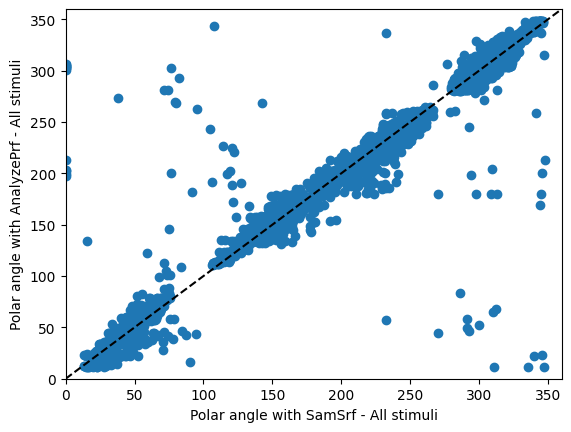

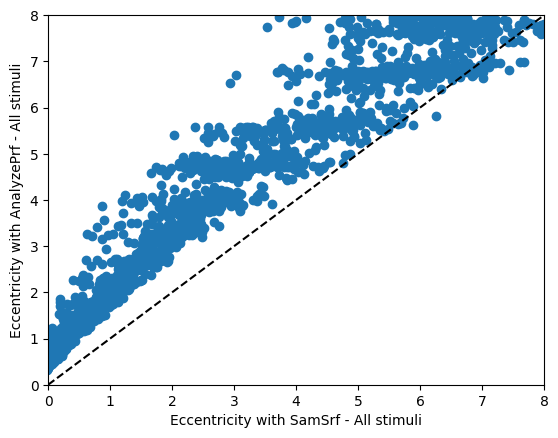

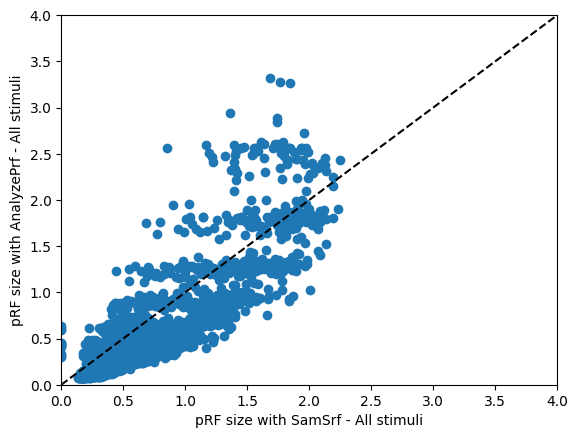

In [73]:
for retinotopic_map in ['polarAngle', 'eccentricity', 'pRFsize']:
    average_samsrf_maps = []
    average_var_samsrf_maps = []
    average_analyzeprf_maps = []
    average_var_analyzeprf_maps =[]

    for hemisphere in ['lh', 'rh']:
        average_samsrf, average_var_samsrf = average_maps(path_to_freesurfer_hcp, list_of_subs_hcp, 'SamSrf', 
                                                        dataset = 'hcp', retinotopic_map = retinotopic_map, hemisphere=hemisphere)
        average_analyzeprf, average_var_analyzeprf = average_maps(path_to_freesurfer_hcp, list_of_subs_hcp, 'AnalyzePRF', 
                                                                dataset= 'hcp', retinotopic_map = retinotopic_map, hemisphere=hemisphere)
        average_samsrf_maps.append(average_samsrf)
        average_var_samsrf_maps.append(average_var_samsrf)
        average_analyzeprf_maps.append(average_analyzeprf)
        average_var_analyzeprf_maps.append(average_var_analyzeprf)
    average_samsrf_maps = np.array(average_samsrf_maps).reshape(-1)
    average_var_samsrf_maps = np.array(average_var_samsrf_maps).reshape(-1)
    average_analyzeprf_maps = np.array(average_analyzeprf_maps).reshape(-1)
    average_var_analyzeprf_maps = np.array(average_var_analyzeprf_maps).reshape(-1)

    plt.scatter(x=average_samsrf_maps[average_var_analyzeprf_maps>10], y=average_analyzeprf_maps[average_var_analyzeprf_maps>10])
    if retinotopic_map == 'polarAngle':
        plt.plot([0, 360], [0, 360], 'k--')
        plt.xlim([0, 360])
        plt.ylim([0, 360])
        plt.xlabel('Polar angle with SamSrf - All stimuli')
        plt.ylabel('Polar angle with AnalyzePrf - All stimuli')
    elif retinotopic_map == 'eccentricity':
        plt.plot([0, 8], [0, 8], 'k--')
        plt.xlim([0, 8])
        plt.ylim([0, 8])
        plt.xlabel('Eccentricity with SamSrf - All stimuli')
        plt.ylabel('Eccentricity with AnalyzePrf - All stimuli')
    else:
        plt.plot([0, 4], [0, 4], 'k--')
        plt.xlim([0, 4])
        plt.ylim([0, 4])
        plt.xlabel('pRF size with SamSrf - All stimuli')
        plt.ylabel('pRF size with AnalyzePrf - All stimuli')
    plt.show()